**Context**  
Sebuah hotel ingin menyiapkan kamar untuk calon pelanggannya. dari catatan yang ada, hotel ingin mengetahui pelanggan mana yang akan benar - benar menginap dan mana yang tidak.


Target :

0 : Tidak membatalkan booking

1 : Membatalkan Booking

<!-- **Problem Statement :**

Proses penyiapan fasilitas seperti kamar pada hotel memakan waktu dan sumber daya. Jika hotel menyiapkan semua fasilitas tetapi tidak digunakan maka akan sia - sia dan hotel dapat merugi.Sedangkan beberapa fasilitas hotel kualitasnya akan menurun tiap waktu (contoh: makanan pada restaurant), sehingga fasilitas harus disiapkan disaat diminta.

**Goals :**

Maka berdasarkan permasalahan tersebut, hotel ingin memiliki kemampuan untuk memprediksi faktor - faktor apa saja yang membuat pelanggan membatalkan booking, sehingga dapat memfokuskan penyiapan fasilitas pada pelanggan yang akan menginap dihotel tersebut. 

Dan juga, jika hotel memiliki pelanngan dalam waiting list , mereka dapat memprioritaskan pelanggan yang tidak dalam kriteria pelanggan yang mebatalkan booking.


**Analytic Approach :**

Jadi yang akan kita lakukan adalah menganalisis data untuk menemukan pola yang membedakan pengunjung yang jadi menginap di hotel dan yang tidak jadi(batal).

Kemudian kita akan membangun model klasifikasi yang akan membantu hotel untuk dapat memprediksi karakteristik engunjung yang akan menginap atau tidak. -->

**Problem Statement**

Manajemen hotel telah mengidentifikasi kekhawatiran mendesak mengenai meningkatnya tingkat pembatalan customer, yang berdampak buruk pada pendapatan dan efisiensi operasional. Tujuannya adalah untuk merumuskan strategi dan intervensi untuk secara signifikan mengurangi jumlah pemesanan hotel yang dibatalkan.


**Goals**

Dengan menghadapi tantangan peningkatan tingkat pembatalan pemesanan oleh pelanggan, hotel berkeinginan untuk mengembangkan kemampuan prediktif guna mengidentifikasi faktor-faktor yang menyebabkan pembatalan. Tujuannya adalah untuk dapat secara strategis menyusun fasilitas berdasarkan kebutuhan pelanggan yang akan menginap. Selain itu, jika terdapat pelanggan dalam daftar tunggu, hotel bermaksud memberikan prioritas kepada pelanggan yang kurang cenderung untuk membatalkan pemesanan, memungkinkan pengelolaan yang lebih efektif terhadap kapasitas kamar yang tersedia.

**Analytic Approach**


Langkah pertama dalam penyelesaian permasalahan ini adalah melakukan analisis data untuk mengidentifikasi pola-pola yang memisahkan antara pengunjung yang berhasil menginap di hotel dengan yang customer yang memutuskan untuk membatalkan menginap. Setelahnya, kita akan mengembangkan sebuah model klasifikasi yang dapat memberikan prediksi terhadap karakteristik pengunjung, membantu hotel dalam mengantisipasi apakah pengunjung tersebut kemungkinan besar akan menginap atau membatalkan reservasinya.


**Evaluation Metrics**

Pada model ini kita akan memprioritaskan untuk meminimalisir orang yang aktualnya cancel namun diprediksi tidak cancel (False Negative), maka dari itu kita akan memaksimalkan score **recall** pada model.

## Data Understanding

### Attribute Information

| Attribute | Data Type | Description |
| --- | --- | --- |
| country | object | Country of origin |
| market_segment| object | Market segment designation |
| previous_cancelation | integer | Number of previous bookings that were cancelled by the customer prior to the current booking |
| booking_changes | integer | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation |
| deposit_type | object | Number of changes/amendments made to the booking from the moment the booking was entered on the PMS until the moment of check-in or cancellation |
| days_in_waiting_list | integer | Number of days the booking was in the waiting list before it was confirmed to the customer |
| customer_type | object | Type of booking |
| reserved_room_type | object | Code of room type reserved. Code is presented instead of designation for anonymity reasons |
| required_car_parking_spaces | integer | Number of car parking spaces required by the customer |
| total_of_special_requests| integer | NNumber of special requests made by the customer (e.g. twin bed or high floor) |
| is_canceled | integer | Value indicating if the booking was canceled (1) or not (0) |


In [233]:
# Library
import pandas as pd
import numpy as np

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

# Feature Engineering
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, OrdinalEncoder, RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
import category_encoders as ce


# Model Selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV,StratifiedKFold,train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score
from sklearn.metrics import roc_curve, roc_auc_score, make_scorer

# Imbalance Dataset
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler, SMOTE
from imblearn.under_sampling import RandomUnderSampler

# Ignore Warning
import sys
import warnings
if not sys.warnoptions:
    warnings.simplefilter("ignore")

# Set max columns
pd.set_option('display.max_columns', None)

In [234]:
df = pd.read_csv('data_hotel_booking_demand.csv')
df.head()

,country,market_segment,previous_cancellations,booking_changes,deposit_type,days_in_waiting_list,customer_type,reserved_room_type,required_car_parking_spaces,total_of_special_requests,is_canceled
0,IRL,Offline TA/TO,0,0,No Deposit,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,No Deposit,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,No Deposit,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,No Deposit,0,Transient,A,0,1,1
4,PRT,Online TA,0,2,No Deposit,0,Transient,A,0,2,0


In [235]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 83573 entries, 0 to 83572
Data columns (total 11 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   country                      83222 non-null  object
 1   market_segment               83573 non-null  object
 2   previous_cancellations       83573 non-null  int64 
 3   booking_changes              83573 non-null  int64 
 4   deposit_type                 83573 non-null  object
 5   days_in_waiting_list         83573 non-null  int64 
 6   customer_type                83573 non-null  object
 7   reserved_room_type           83573 non-null  object
 8   required_car_parking_spaces  83573 non-null  int64 
 9   total_of_special_requests    83573 non-null  int64 
 10  is_canceled                  83573 non-null  int64 
dtypes: int64(6), object(5)
memory usage: 7.0+ MB


In [236]:
df.describe()

,previous_cancellations,booking_changes,days_in_waiting_list,required_car_parking_spaces,total_of_special_requests,is_canceled
count,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000,83573.000000
mean,0.086798,0.220897,2.330561,0.062999,0.573211,0.368277
std,0.841011,0.648635,17.673051,0.246919,0.795163,0.482340
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000
max,26.000000,21.000000,391.000000,8.000000,5.000000,1.000000


In [237]:
df.describe(include= 'O')

,country,market_segment,deposit_type,customer_type,reserved_room_type
count,83222,83573,83573,83573,83573
unique,162,8,3,4,10
top,PRT,Online TA,No Deposit,Transient,A
freq,34097,39460,73352,62732,60041


## Data Cleaning

### Mengubah Format Nama Kolom

In [238]:
# Format Kolom agar sedikit rapih
df.columns = [s.strip().replace('_',' ') for s in df.columns]

### Data Duplikat

In [239]:
# cek duplikat
df.duplicated().sum()

73371

In [240]:
df.shape

(83573, 11)

In [241]:
# menghapus data duplikat
df.drop_duplicates(inplace=True)

In [242]:
df.shape

(10202, 11)

### Cek missing value

In [243]:
listItem = []
for col in df.columns :
    listItem.append([col, df[col].dtype, df[col].isna().sum(), round((df[col].isna().sum()/len(df[col])) * 100,2),
                    df[col].nunique(), list(df[col].drop_duplicates().sample(2).values)]);

dfDesc = pd.DataFrame(columns=['dataFeatures', 'dataType', 'null', 'nullPct', 'unique', 'uniqueSample'],
                     data=listItem)
dfDesc

,dataFeatures,dataType,null,nullPct,unique,uniqueSample
0,country,object,118,1.16,162,"[BHR, VNM]"
1,market segment,object,0,0.00,8,"[Offline TA/TO, Aviation]"
2,previous cancellations,int64,0,0.00,15,"[3, 24]"
3,booking changes,int64,0,0.00,19,"[12, 6]"
4,deposit type,object,0,0.00,3,"[No Deposit, Refundable]"
5,days in waiting list,int64,0,0.00,115,"[147, 35]"
6,customer type,object,0,0.00,4,"[Group, Contract]"
7,reserved room type,object,0,0.00,10,"[D, E]"
8,required car parking spaces,int64,0,0.00,5,"[1, 0]"
9,total of special requests,int64,0,0.00,6,"[0, 3]"


In [244]:
# menghapus data yg memiliki missing values
df.dropna(inplace=True)

In [245]:
df.isna().sum()

country                        0
market segment                 0
previous cancellations         0
booking changes                0
deposit type                   0
days in waiting list           0
customer type                  0
reserved room type             0
required car parking spaces    0
total of special requests      0
is canceled                    0
dtype: int64

### Binning

Kita akan melakukan binning untuk kolom `previous cancellations`, `booking changes`, `deposit type`, dan `days in waiting list`. Untuk semua kolom kecuali `deposit type` kita akan mengganti data yg bernilai 0 menjadi 0 dan data yang bernilai > 0 menjadi 1 (seperti menjadi True dan False), sedangkan untuk kolom `deposit type` kita akan mengganti data yang bernilai `No Deposit` menjadi 0 dan data lainnya menjadi 1. Lalu kita akan mengganti ke-4 nama kolom tersebut agar sesuai dengan data hasil binning yang kita isi.

In [246]:
# binning
df['previous cancellations'] = df['previous cancellations'].apply(lambda x: 0 if x == 0 else 1)
df['booking changes'] = df['booking changes'].apply(lambda x: 0 if x == 0 else 1)
df['deposit type'] = df['deposit type'].apply(lambda x: 0 if x == 'No Deposit' else 1)
df['days in waiting list'] = df['days in waiting list'].apply(lambda x: 0 if x == 0 else 1)


In [247]:
# Merubah beberapa nama kolom
df.rename(columns={'deposit type': 'deposit','previous cancellations':'ever cancel','booking changes':'book change','days in waiting list':'waiting list'},inplace=True)

### Cek nilai jumlah unik kolom kategorikal

In [248]:
df.describe(include='O')

,country,market segment,customer type,reserved room type
count,10084,10084,10084,10084
unique,162,8,4,10
top,PRT,Online TA,Transient,A
freq,1993,4924,6813,4562


**country**

In [249]:
count_country = df['country'].value_counts().to_frame()
count_country

,count
country,
PRT,1993
GBR,734
ESP,641
FRA,612
DEU,432
...,...
LCA,1
ZMB,1
GTM,1


Kita akan mengubah nama country yang memiliki count value < 5 menjadi 'Other'.

In [250]:
country1 = count_country[count_country['count'] < 5].index
country1

Index(['CMR', 'TZA', 'FRO', 'ETH', 'CUB', 'GHA', 'ZWE', 'KEN', 'GAB', 'LKA',
       'SYR', 'MUS', 'CIV', 'BHR', 'MAC', 'CAF', 'MNE', 'SUR', 'ABW', 'TMP',
       'TGO', 'GGY', 'SLV', 'COM', 'PRY', 'IMN', 'UZB', 'LIE', 'BOL', 'TJK',
       'BEN', 'SDN', 'PLW', 'MLI', 'KNA', 'MMR', 'BFA', 'MYT', 'UGA', 'ATA',
       'KIR', 'VGB', 'DMA', 'BDI', 'NIC', 'NCL', 'BWA', 'SLE', 'CYM', 'BRB',
       'MWI', 'RWA', 'LAO', 'GLP', 'KHM', 'SYC', 'LCA', 'ZMB', 'GTM', 'UMI',
       'AIA'],
      dtype='object', name='country')

In [251]:
df.loc[df[df['country'].isin(country1)].index, 'country'] = 'Other'

In [252]:
df['country'].value_counts()

country
PRT    1993
GBR     734
ESP     641
FRA     612
DEU     432
       ... 
AND       5
JEY       5
LBY       5
BGD       5
GNB       5
Name: count, Length: 102, dtype: int64

**market segment**

In [253]:
df['market segment'].value_counts()

market segment
Online TA        4924
Direct           2079
Offline TA/TO    1469
Groups            845
Corporate         505
Complementary     180
Aviation           81
Undefined           1
Name: count, dtype: int64

Kita akan menghapus data yang meiliki market segment bernilai 'Undefined'.

In [254]:
df = df[df['market segment'] != 'Undefined']

In [255]:
df['market segment'].value_counts()

market segment
Online TA        4924
Direct           2079
Offline TA/TO    1469
Groups            845
Corporate         505
Complementary     180
Aviation           81
Name: count, dtype: int64

**customer type**

In [256]:
df['customer type'].value_counts()

customer type
Transient          6813
Transient-Party    2548
Contract            481
Group               241
Name: count, dtype: int64

data customer type sudah clean, maka kita akan membiarkannya.

**reserved room type**

In [257]:
df['reserved room type'].value_counts()

reserved room type
A    4562
D    2025
E    1248
F     715
G     546
B     453
C     339
H     192
L       2
P       1
Name: count, dtype: int64

Kita akan menghapus data yang memiliki reserved room type bernilai 'L' dan 'P'.

In [258]:
df= df[~df['reserved room type'].isin(['L','P'])]

In [259]:
df['reserved room type'].value_counts()

reserved room type
A    4562
D    2025
E    1248
F     715
G     546
B     453
C     339
H     192
Name: count, dtype: int64

### Cek proporsi target

In [260]:
df['is canceled'].value_counts(normalize=True)

is canceled
0    0.762599
1    0.237401
Name: proportion, dtype: float64

In [261]:
df_target = df['is canceled'].value_counts(normalize=True).to_frame().reset_index()


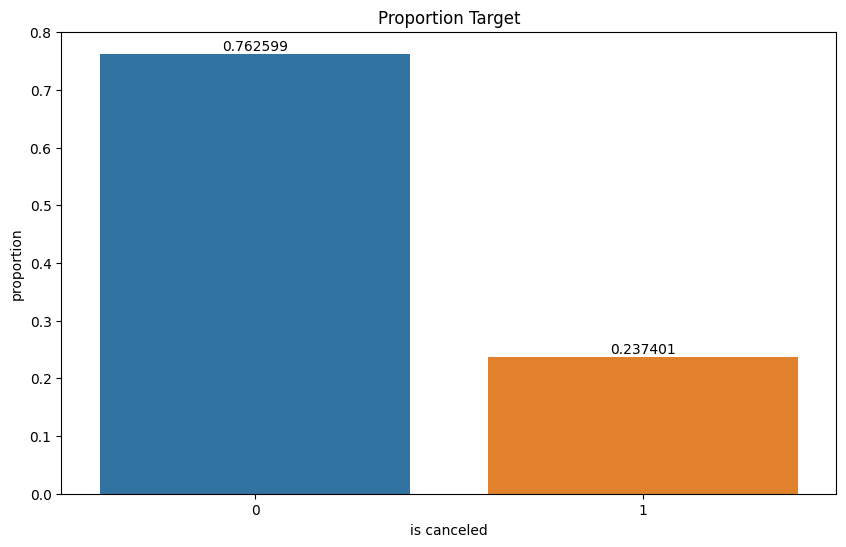

In [262]:
plt.figure(figsize=(10, 6))
plt.title('Proportion Target')
ax = sns.barplot(df_target, x= 'is canceled', y= 'proportion')
ax.bar_label(ax.containers[0])
plt.show()

Proporsi target dapat dibilang cukup imbalance, maka dari itu kita akan menggunakan resampler saat modeling.

### Correlation Matrix

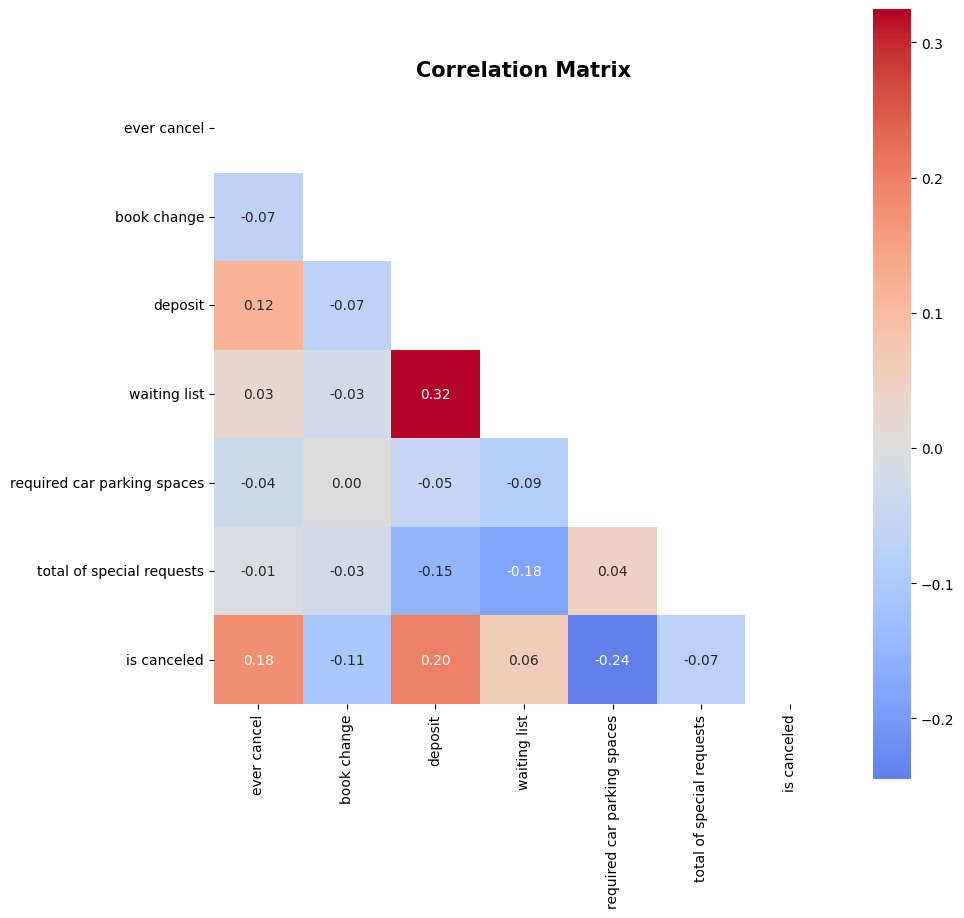

In [263]:
# Correlation matrix
plt.figure(figsize=(10,10))

matrix = np.triu(df.corr(method='spearman', numeric_only=True))

sns.heatmap(data=df.corr(method='spearman', numeric_only=True), annot=True, fmt='.2f', cmap='coolwarm', center=0, mask = matrix, square='True')
plt.title('Correlation Matrix', size=15, weight='bold')
plt.show()

Correlation matrix menunjukkan bahwa tidak ada fitur yang memiliki korelasi yang kuat terhadap target (`is canceled`). Korelasi paling tinggi dimiliki oleh fitur `required car parking spaces`, di mana korelasinya adalah korelasi negatif. Hal ini menunjukkan bahwa semakin sedikit tempat parkir yang dibutuhkan, semakin besar kemungkinan booking tersebut akan di cancel.

### Clean Data

In [264]:
df.head()

,country,market segment,ever cancel,book change,deposit,waiting list,customer type,reserved room type,required car parking spaces,total of special requests,is canceled
0,IRL,Offline TA/TO,0,0,0,0,Transient-Party,A,0,0,0
1,FRA,Online TA,0,0,0,0,Transient,A,0,2,0
2,PRT,Online TA,0,1,0,0,Transient,A,0,2,0
3,NLD,Online TA,0,0,0,0,Transient,A,0,1,1
4,PRT,Online TA,0,1,0,0,Transient,A,0,2,0


## EDA

**Market segment vs target**

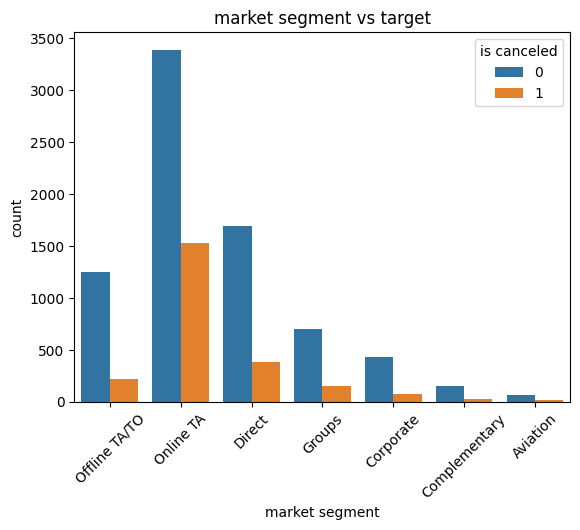

In [265]:
sns.countplot(data= df, x= 'market segment', hue= 'is canceled')
plt.title('market segment vs target')
plt.xticks(rotation= 45)
plt.show()

Customer yang tipe market segmentnya Online TA memiliki jumlah customer yang cancel paling banyak dibandingkan dengan market segment lainnya.

**Customer Type vs target**

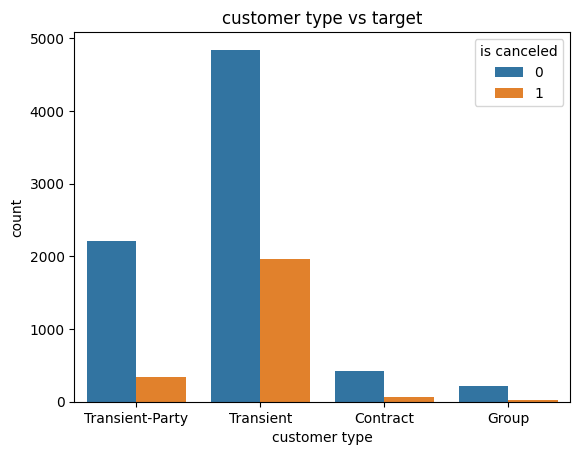

In [266]:
sns.countplot(data= df, x= 'customer type', hue= 'is canceled')
plt.title('customer type vs target')
plt.xticks(rotation= 0)
plt.show()

Customer yang bertipe Transient memiliki jumlah customer yang cancel paling banyak dibandingkan dengan tipe customer lainnya.

**reserved room type vs target**

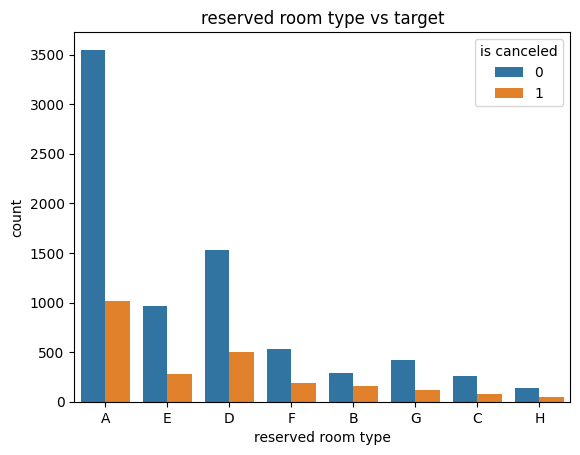

In [267]:
sns.countplot(data= df, x= 'reserved room type', hue= 'is canceled')
plt.title('reserved room type vs target')
plt.xticks(rotation= 0)
plt.show()

Customer yang memesan kamar bertipe A memiliki jumlah customer yang cancel paling banyak dibandingkan dengan tipe kamar lainnya.

**ever cancel vs target**

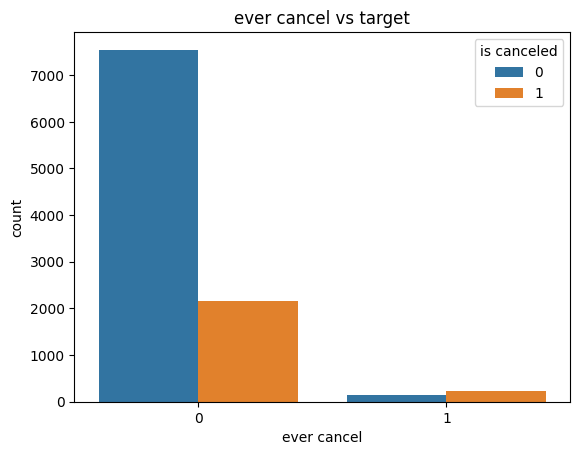

In [268]:
sns.countplot(data= df, x= 'ever cancel', hue= 'is canceled')
plt.title('ever cancel vs target')
plt.xticks(rotation= 0)
plt.show()

Customer yang sebelumnya pernah mengcancel booking mereka memiliki kemungkinan akan mengcancel bookingnya lagi lebih besar dibanding customer yang tidak pernah mengcancel booking mereka sebelumnya.

**deposit vs target**

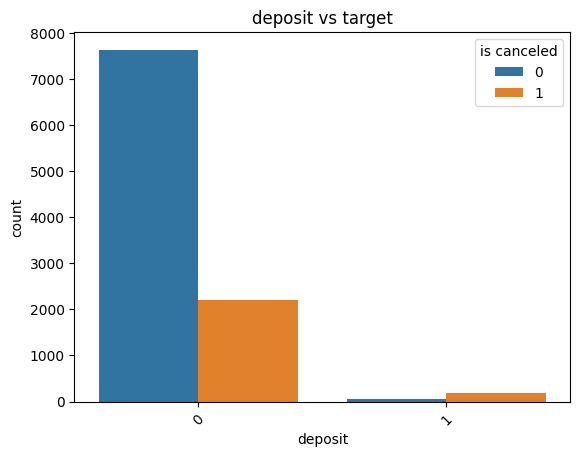

In [269]:
sns.countplot(data= df, x= 'deposit', hue= 'is canceled')
plt.title('deposit vs target')
plt.xticks(rotation= 45)
plt.show()

Customer yang melakukan deposit memiliki proporsi cancel paling banyak dibandingkan dengan customer yang tidak melakukan deposit.

**book change vs target**

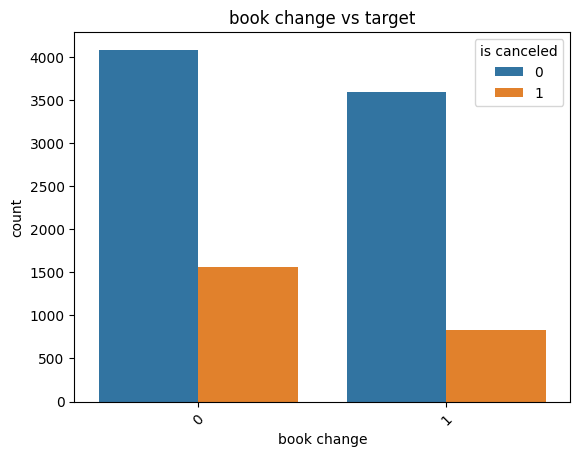

In [270]:
sns.countplot(data= df, x= 'book change', hue= 'is canceled')
plt.title('book change vs target')
plt.xticks(rotation= 45)
plt.show()

Customer yang tidak mengganti bookingnya memiliki jumlah customer yang cancel paling banyak dibandingkan dengan customer yang mengganti bookingnya lainnya.

**waiting list vs target**

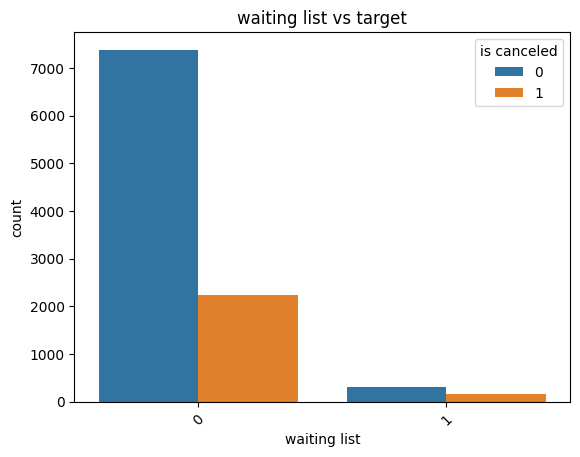

In [271]:
sns.countplot(data= df, x= 'waiting list', hue= 'is canceled')
plt.title('waiting list vs target')
plt.xticks(rotation= 45)
plt.show()

Customer yang masuk waiting list memiliki jumlah proporsi yang cancel paling banyak dibandingkan dengan customer yang tidak masuk waiting list.

## **Modeling**

In [272]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
import category_encoders as ce
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split

## Data Preparation

### Encoding

In [273]:
# menampilkan jumlah unik dan unique values untuk setiap kolom
pd.set_option('display.max_colwidth', None)
# data unik di tiap kolom
listItem = []
categorical_features = df.drop(columns= 'is canceled').describe(include='O').columns
for col in categorical_features :
    listItem.append( [col, df[col].nunique(), df.sort_values(col)[col].unique()])

tabel1Desc = pd.DataFrame(columns=['Column Name', 'Number of Unique', 'Unique Values'],
                     data=listItem)
tabel1Desc

,Column Name,Number of Unique,Unique Values
0,country,102,"[AGO, ALB, AND, ARE, ARG, ARM, AUS, AUT, AZE, BEL, BGD, BGR, BIH, BLR, BRA, CHE, CHL, CHN, CN, COL, CPV, CRI, CYP, CZE, DEU, DNK, DOM, DZA, ECU, EGY, ESP, EST, FIN, FRA, GBR, GEO, GIB, GNB, GRC, HKG, HRV, HUN, IDN, IND, IRL, IRN, IRQ, ISL, ISR, ITA, JAM, JEY, JOR, JPN, KAZ, KOR, KWT, LBN, LBY, LTU, LUX, LVA, MAR, MDV, MEX, MKD, MLT, MOZ, MYS, NGA, NLD, NOR, NZL, OMN, Other, PAK, PAN, PER, PHL, POL, PRI, PRT, QAT, ROU, RUS, SAU, SEN, SGP, SRB, SVK, SVN, SWE, THA, TUN, TUR, TWN, UKR, URY, USA, VEN, ...]"
1,market segment,7,"[Aviation, Complementary, Corporate, Direct, Groups, Offline TA/TO, Online TA]"
2,customer type,4,"[Contract, Group, Transient, Transient-Party]"
3,reserved room type,8,"[A, B, C, D, E, F, G, H]"


OneHotEncoding -> `market segment`, `customer type`, `reserved room type`\
BinaryEncoding -> `country`

In [274]:
#encoding
transformer=ColumnTransformer([
    ('onehot',OneHotEncoder(drop='first'),['market segment', 'customer type', 'reserved room type']),
    ('binary',ce.BinaryEncoder(),['country'])
],remainder='passthrough')

### Define Features (X) and Target (y)

In [275]:
X = df.drop(columns= 'is canceled')
y = df['is canceled']

### Train Test Splitting

In [276]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify= y)

### Scaler

In [277]:
robust = RobustScaler()

### Resampler

In [278]:
smote = SMOTE(random_state=0)

### Model Benchmarking

In [279]:
logreg = LogisticRegression(random_state=0)
knn = KNeighborsClassifier()
dt = DecisionTreeClassifier(random_state=0)
rf = RandomForestClassifier(random_state=0)
xgb = XGBClassifier(random_state=0)

In [280]:
models = [logreg,knn,dt,rf, xgb]

list_mean = []
list_std = []
list_score = []

for algoritma in models:

    pipe_model=Pipeline([
        ('preprocess', transformer),
        ('scaler', robust),
        ('resample', smote),
        ('model', algoritma)
    ])

    skfold = StratifiedKFold(n_splits=5)

    model_cv = cross_val_score(
        estimator=pipe_model,
        X=X_train,
        y=y_train,
        cv=skfold,
        scoring= 'recall'
    )

    list_mean.append(model_cv.mean())
    list_std.append(model_cv.std())
    list_score.append(model_cv.round(3))

In [281]:
pd.DataFrame({
    'model' : ['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'mean recall' : list_mean,
    'std recall' : list_std,
    'score' : list_score
})

,model,mean recall,std recall,score
0,Logistic Regression,0.782120,0.030880,"[0.841, 0.775, 0.781, 0.755, 0.759]"
1,KNN,0.590390,0.030509,"[0.64, 0.577, 0.593, 0.546, 0.597]"
2,Decision Tree,0.302522,0.024259,"[0.329, 0.303, 0.279, 0.272, 0.33]"
3,Random Forest,0.355804,0.021937,"[0.381, 0.366, 0.352, 0.316, 0.364]"
4,XGBoost,0.437311,0.007877,"[0.436, 0.441, 0.428, 0.431, 0.45]"


### Predict to Test Set

In [282]:
list_recall_score = []

# Mencari model terbaik berdasarkan f1 score terbesar dan std terkecil
for algoritma in models :

    pipe_model=Pipeline([
        ('preprocess', transformer),
        ('scaler', robust),
        ('resampler', smote),
        ('model', algoritma)
    ])

    # fitting
    pipe_model.fit(X_train, y_train)

    # predict
    y_pred = pipe_model.predict(X_test)

    # evaluate
    score = recall_score(y_test, y_pred)
    list_recall_score.append(score)

In [283]:
# Perbandingan performa antar model
pd.DataFrame({
    'model':['Logistic Regression', 'KNN', 'Decision Tree', 'Random Forest', 'XGBoost'],
    'recall_score (test_set)': list_recall_score,
})

,model,recall_score (test_set)
0,Logistic Regression,0.797495
1,KNN,0.626305
2,Decision Tree,0.252610
3,Random Forest,0.348643
4,XGBoost,0.486430


Kita akan memilih Logistic Regression sebagai best model kita, karena model tersebut memiliki nilai recall yang paling tinggi dibandingkan dengan model-model yang lain.

### Hyperparameter Tuning

In [284]:
rus = RandomUnderSampler(random_state=0)
ros = RandomOverSampler(random_state=0)

In [285]:
penalty= ['l1', 'l2', 'elasticnet', 'none']
C= [0.001, 0.01, 0.1, 1, 10, 100, 1000]
solver= ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
multi_class= ['ovr', 'multinomial']
max_iter= [50, 100, 200, 500, 1000]

In [286]:
hyperparam_space_logreg = {
    'resampler':[smote, rus, ros],
    'model__penalty':penalty,
    'model__C':C,
    'model__max_iter':max_iter,
    'model__multi_class':multi_class,
    'model__solver':solver
}

In [287]:
# Benchmark model 
logreg = LogisticRegression(random_state=0)

# Stratified cross validation
skf = StratifiedKFold(n_splits = 5)

# Create the algorithm chains
estimator_logreg = Pipeline([
    ('preprocess', transformer),
    ('scaler', robust),
    ('resampler', smote), 
    ('model', logreg)
    ])

# Hyperparameter tuning
random_logreg = RandomizedSearchCV(
    estimator=estimator_logreg, 
    param_distributions = hyperparam_space_logreg, 
    cv = skf, 
    scoring = 'recall', 
    n_iter=500,
    n_jobs = -1,
    random_state=0
)

In [288]:
# fitting 
random_logreg.fit(X_train, y_train)

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1183: FutureWarning: `penalty='none'`has been deprecated in 1.2 and will be removed in 1.4. To keep the past behaviour, set `penalty=None`.
  warnings.warn(
/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:1193: UserWarning: Setting penalty=None will ignore the C and l1_ratio parameters
  warnings.warn(
/Library/Frameworks/Python.frame

RandomizedSearchCV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
                   estimator=Pipeline(steps=[('preprocess',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('onehot',
                                                                               OneHotEncoder(drop='first'),
                                                                               ['market '
                                                                                'segment',
                                                                                'customer '
                                                                                'type',
                                                                                'reserved '
                                                                                'room '
                                                                                'type']),
                                                                              ('binary',
                                                                               BinaryEncoder(),
                                                                               ['country'])])),
                                             ('scaler', RobustScaler()),
                                             ('res...
                   param_distributions={'model__C': [0.001, 0.01, 0.1, 1, 10,
                                                     100, 1000],
                                        'model__max_iter': [50, 100, 200, 500,
                                                            1000],
                                        'model__multi_class': ['ovr',
                                                               'multinomial'],
                                        'model__penalty': ['l1', 'l2',
                                                           'elasticnet',
                                                           'none'],
                                        'model__solver': ['newton-cg', 'lbfgs',
                                                          'liblinear', 'sag',
                                                          'saga'],
                                        'resampler': [SMOTE(random_state=0),
                                                      RandomUnderSampler(random_state=0),
                                                      RandomOverSampler(random_state=0)]},
                   random_state=0, scoring='recall')

In [289]:
random_logreg.best_score_

0.7972837751014995

In [290]:
random_logreg.best_params_

{'resampler': RandomOverSampler(random_state=0),
 'model__solver': 'saga',
 'model__penalty': 'l1',
 'model__multi_class': 'multinomial',
 'model__max_iter': 200,
 'model__C': 0.01}

In [291]:
# menggunakan model terbaik hasil randomizedsearch
tuned_model = random_logreg.best_estimator_

# fitting
tuned_model.fit(X_train, y_train)

# predict
y_pred_tuned = tuned_model.predict(X_test)

# evaluate (recall score)
recall_score(y_test, y_pred_tuned)

0.8079331941544885

In [292]:
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.92      0.65      0.76      1537
           1       0.42      0.81      0.55       479

    accuracy                           0.69      2016
   macro avg       0.67      0.73      0.65      2016
weighted avg       0.80      0.69      0.71      2016



### Performance Comparisson

In [293]:
pipe_model=Pipeline([
        ('preprocess', transformer),
        ('scaler', robust),
        ('resampler', smote),
        ('model', logreg)
    ])

# fitting
pipe_model.fit(X_train, y_train)

# predict
y_pred = pipe_model.predict(X_test)

# evaluate
recall_score(y_test, y_pred)

0.7974947807933194

In [294]:
pd.DataFrame({
    'model' : ['Logistic Regression'],
    'score before tuning' : [recall_score(y_test, y_pred)],
    'score after tuning' : [recall_score(y_test, y_pred_tuned)],
})

,model,score before tuning,score after tuning
0,Logistic Regression,0.797495,0.807933


In [295]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.92      0.69      0.78      1537
           1       0.44      0.80      0.57       479

    accuracy                           0.71      2016
   macro avg       0.68      0.74      0.68      2016
weighted avg       0.80      0.71      0.73      2016



In [296]:
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.92      0.65      0.76      1537
           1       0.42      0.81      0.55       479

    accuracy                           0.69      2016
   macro avg       0.67      0.73      0.65      2016
weighted avg       0.80      0.69      0.71      2016



Terlihat bahwa model Logistic Regression setelah kita tuning hyperparameternya memiliki nilai recall yang lebih baik walaupun hanya lebih baik sedikit saja. Oleh karena itu kita akan menggunakan model Logistic Regression yang sudah di tuning sebagai model akhir kita.

### Coefficient

In [297]:
df_coef = pd.DataFrame(tuned_model['model'].coef_[0], transformer.get_feature_names_out()).rename(columns={0 : 'coef'})
df_coef['coef'] = df_coef['coef'].apply(lambda x : np.abs(x))
df_coef = df_coef.sort_values('coef', ascending=False)
df_coef.reset_index(inplace=True)
df_coef

,index,coef
0,remainder__required car parking spaces,1.392243
1,onehot__customer type_Transient,0.463970
2,onehot__market segment_Online TA,0.427669
3,remainder__ever cancel,0.319516
4,remainder__deposit,0.226396
5,remainder__total of special requests,0.219288
6,binary__country_5,0.183505
7,remainder__book change,0.174265
8,binary__country_4,0.109777
9,binary__country_6,0.103249


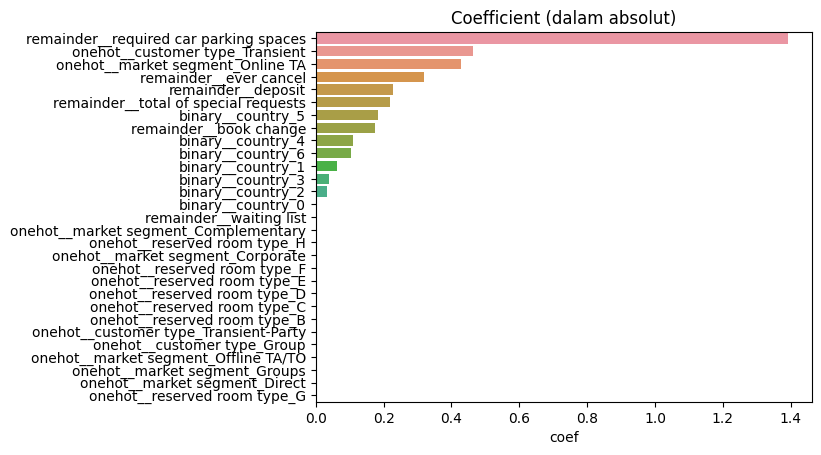

In [298]:
sns.barplot(df_coef, y= 'index', x='coef')
plt.ylabel('')
plt.title('Coefficient (dalam absolut)')
plt.show()

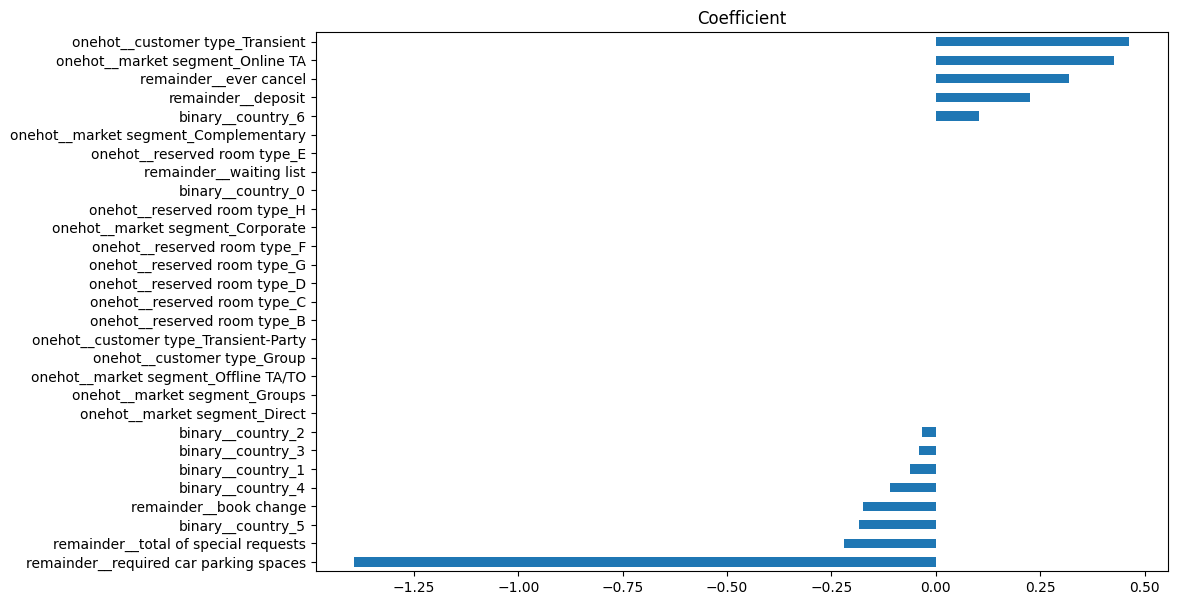

In [304]:
plt.figure(figsize= (11,7))
coef1 = pd.Series(tuned_model['model'].coef_[0], transformer.get_feature_names_out()).sort_values(ascending = False)
coef1[::-1].plot(kind='barh', title='Coefficient')
plt.show()

Terdapat beberapa fitur yang mempunyai coefficient bernilai 0. Karena penalty pada model ini merupakan 'l1', maka beberapa fitur dapat saja mempunyai coefficient yang bernilai 0. 5 fitur yang paling penting pada model ini adalah `required car parking spaces`, `customer type`, `market segment`, `ever cancel`, `deposit`. kemudian fitur yang memiliki coefficient yang paling tinggi adalah `required car parking spaces` dengan angka bernilai negatif. hal ini menunjukan bahwa semakin tempat parkir yang dibutuhkan maka semakin kecil kemungkinan customer tersebut akan **cancel**

### Confusion Matrix

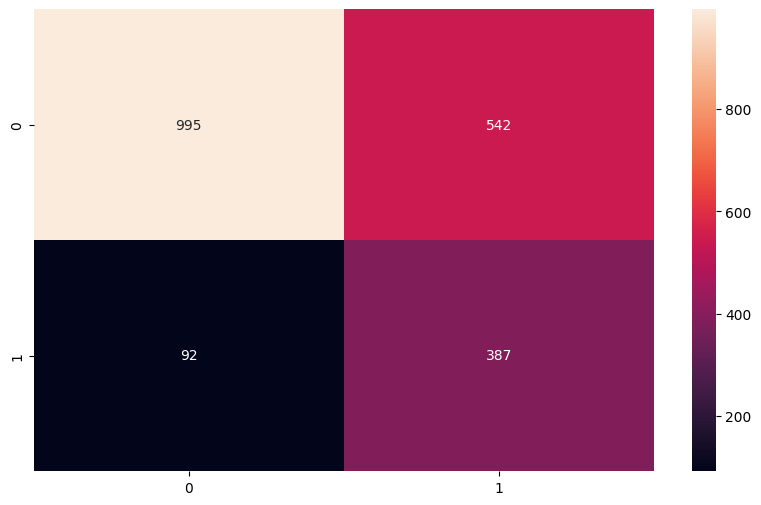

In [300]:
plt.figure(figsize=(10, 6))
sns.heatmap(confusion_matrix(y_test, y_pred_tuned), annot=True, fmt= '.0f')
plt.show()

## Conclusion & Recommendation

In [301]:
print(classification_report(y_test, y_pred_tuned))

              precision    recall  f1-score   support

           0       0.92      0.65      0.76      1537
           1       0.42      0.81      0.55       479

    accuracy                           0.69      2016
   macro avg       0.67      0.73      0.65      2016
weighted avg       0.80      0.69      0.71      2016



Berdasarkan hasil classification report dari model kita, kita dapat menyimpulkan/mengambil konklusi bahwa bila seandainya nanti kita menggunakan model kita untuk memfilter/menyaring list customer yang akan dilayani sepenuhnya, maka model kita dapat mengurangi 65% customer yang akan mengcancel bookingnya untuk tidak kita layani dengan maksimal, dan model kita dapat mendapatkan 81% customer yang akan mengcancel dari seluruh customer yang akan mengcancel. (semua ini berdasarkan recallnya)

Model kita ini memiliki ketepatan prediksi customer yang akan mengcancel sebesar 42% (precisionnya), jadi setiap model kita memprediksi bahwa seorang customer itu akan mengcancel, maka kemungkinan tebakannya benar itu sebesar 42% kurang lebih. Maka masih akan ada customer yang sebenarnya tidak akan mengcancel tetapi diprediksi sebagai customer yang mengcancel sekitar 35% dari keseluruhan customer yang tidak akan mengcancel.

Bila seandainya biaya untuk menyiapkan 1 kamar hotel adalah 50$ dan ada 2016 customer yang ingin membooking (1537 tidak cancel dan 479 lainnya akan cancel) maka perhitungannya kurang lebih akan menjadi seperti ini:

Tanpa Model (semua customer kita layani) :
- Total Biaya => 2016 x 50 USD = 100800 USD
- Total customer tidak cancel yang dilayani => 1537 orang (karena semua kita layani)
- Total customer tidak cancel yang tidak dilayani => 0 orang (karena semua kita layani)
- Biaya yang terbuang => 479 x 50 USD = 23950 USD (karena 100 orang mengcancel dan menjadi sia-sia)
- Jumlah penghematan => 0 USD

Dengan Model (hanya customer yang diprediksi oleh model tidak cancel yang akan dilayani) :
- Total Biaya => (995 x 50 USD) + (92 x 50 USD) = 54350 USD
- Total customer tidak cancel yang dilayani => 995 orang (karena recall 1 atau yg tidak cancel itu 81%)
- Total customer tidak cancel yang tidak dilayani => 542 orang (karena recall 1 atau yg tertarik itu 81%)
- Biaya yang terbuang => 92 x 50 USD = 4600 USD (berdasarkan recall 0 atau yg akan cancel (92 orang akan cancel))
- Jumlah penghematan => 387 x 50 USD = 19350 USD


Berdasarkan contoh perhitungan diatas, terlihat bahwa menggunakan model kita, maka hotel tersebut akan menghemat biaya yang cukup besar dengan mengorbankan beberapa customer yang aktualnya tidak akan mengcancel.

#### Recommendation

Hal-hal yang bisa dilakukan untuk mengembangkan project dan modelnya lebih baik lagi :
- Membuat kebijakan baru untuk memberikan denda pada customer-customer yang mengcancel bookingnya dengan harapan mengurangi jumlah customer yang akan mengcancel bookingnya. 
- Menambahkan fitur2 atau kolom2 baru yang kemungkinan bisa berhubungan dengan karakteristik customer.
- Mencoba algorithm ML yang lain dan juga mencoba hyperparameter tuning kembali. 
- Menganalisa data-data yang model kita masih salah prediksi untuk mengetahui alasannya dan karakteristiknya bagaimana.